## Notebook Overview

There are several parts in this notebook.

**StyleGAN2 Blend Params Multi Seed Search** - for experimenting with blending parameters on mutliple seeds at once.


**StyleGAN2 Single Seed Blend Params Grid Search** - for performing a grid search on a single seed to establish results of different blend weights combinations.


**StyleGAN2 All Checkpoints Search** - for seeing how different checkpoints perform under same blend weights on multiple seeds at once.


**Make Paired Dataset** - for creating a paired dataset when you found the right blend weights combination.


**Upscale Dataset** - for upscaling created dataset to 512x512 resolution for better quality.

In [14]:
# Uncomment if first time running
# !pip install ninja
# !git clone https://github.com/NVlabs/stylegan3
%cd stylegan3

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import pickle, torch, PIL, copy, cv2, math
import numpy as np
from PIL import Image, ImageEnhance
import os
from tqdm import tqdm
import glob

def get_model(path):
    with open(path, 'rb') as f:
        _G = pickle.load(f)['G_ema'].cuda()
    return _G

#tensor to PIL image 
def t2i(t):
    return Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

#stack an array of PIL images horizontally
def add_imgs(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im


def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()
 
def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)
 
    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)
 
    return matrix

# A simple color correction script to brighten overly dark images
def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100
 
    half_percent = percent / 200.0
 
    channels = cv2.split(img)
 
    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)
 
        assert len(flat.shape) == 1
 
        flat = np.sort(flat)
 
        n_cols = flat.shape[0]
 
        low_val  = flat[math.floor(n_cols * half_percent)-1]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))-1]
 
 
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)
 
    return cv2.merge(out_channels)
 
def normalize(inf, thresh):
    img = np.array(inf)
    out_img = simplest_cb(img, thresh)
    return Image.fromarray(out_img)

    
def get_concat_hor(imgs):
    dst = Image.new('RGB', (imgs[0].width * len(imgs), imgs[0].height))
    cur_val = 0
    for i, img in enumerate(imgs):
        dst.paste(img, (cur_val, 0))
        cur_val += imgs[0].width
    return dst

def get_concat_ver(imgs):
    dst = Image.new('RGB', (imgs[0].width, imgs[0].height * len(imgs)))
    cur_val = 0
    for i, img in enumerate(imgs):
        dst.paste(img, (0, cur_val))
        cur_val += imgs[0].height
    return dst


def stack_imgs(imgs, h, v):
    h *= 2
    v *= 2
    rows = []
    for i in range(0, len(imgs), h):
        row = imgs[i: i + h]
        row = get_concat_hor(row)
        rows.append(row)
    return get_concat_ver([row for row in rows])

def display_info(params):
    print("Info:")
    for key, value in params.items():
        print(f"{key}: {value}")

In [3]:
def blend_models(G_orig, G_finetuned, G_blended, blend): 
    newDictSynt = G_finetuned.synthesis.state_dict().copy()
    GSyntKeys = G_orig.synthesis.state_dict().keys()

    for key in GSyntKeys:
        if key[:1] != 'b': 
            continue
        if 'conv' in key:
            l = blend[key.split('.')[0][1:]]
            newDictSynt[key] = newDictSynt[key] * l + G_orig.synthesis.state_dict()[key] * (1 - l)

    G_blended.synthesis.load_state_dict(newDictSynt)

# StyleGAN2 Blend Params Multi Seed Search

In [4]:
# Download pretrained real faces generator, uncomment if first time running
# !wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl

Info:
PSI: 0.4
CUTOFF: 10
NORM: 0.5
COLOR: 1.0
START_SEED: 0
END_SEED: 18
BLEND: {'4': 0.0, '8': 0.0, '16': 0.5, '32': 0.5, '64': 0.7, '128': 0.7, '256': 0.7}
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


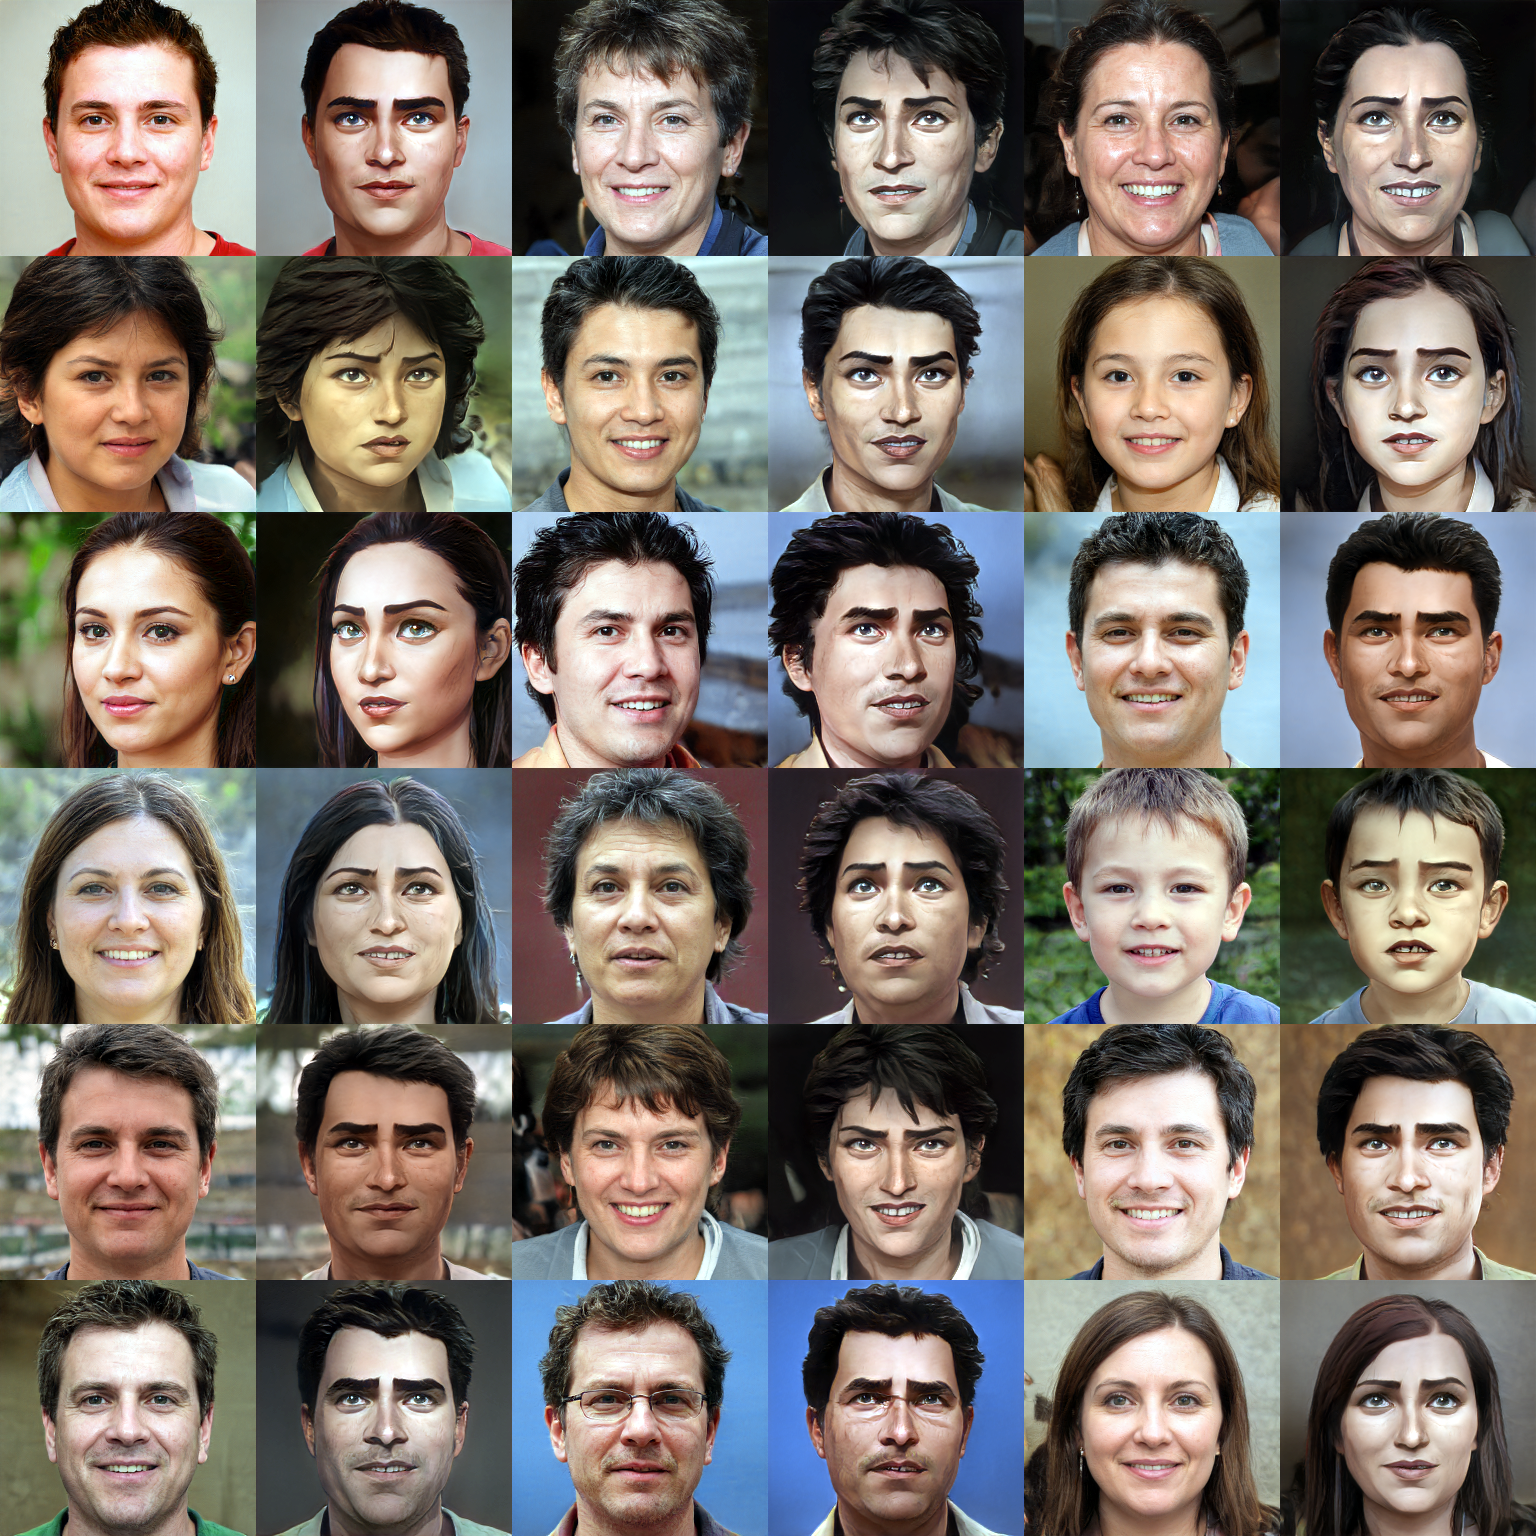

In [5]:
# Load pretrained real faces generator
net_raw = 'stylegan2-ffhq-256x256.pkl'
G_orig =  get_model(net_raw)

# Specify path and load your fine-tuned faces generator
net_tuned = "/path/to/training-runs/00033-v1.8-stylegan2--gpus1-batch16-gamma6.6/network-snapshot-000020.pkl"
G_finetuned = get_model(net_tuned)

G_blended = copy.deepcopy(G_orig)

# Blend dict. Overall suggestions (heavy fine-tuning will still be required):
# Lower resolutions (4, 8) change blended output significantly. Should probably always be set to 0.
# Middle resolutions (16, 32) may be set to [0, 0.5].
# Higher resolutions (64 - 256) may be set to higher values [0.5, 1.0].
BLEND = {
    '4':0.,
    '8':0.,
    '16':0.5,
    '32':0.5,
    '64':0.7,
    '128':0.7,
    '256':0.7}
# Load blended weights into G_blended
blend_models(G_orig=G_orig, G_finetuned=G_finetuned, G_blended=G_blended, blend=BLEND)
# Lower PSI results in better images, but less diversity. Can be set to 0.3-0.5
PSI = 0.4
# Higher cutoff results in better image quality. May be set to 8+.
CUTOFF = 10
# Which seeds to use for generation
START_SEED, END_SEED= 0, 18
# Number of image pairs to be stacke horizontally and vertically in grid
HFACES, VFACES = 3, 6
# Increase image color. 1 means no color correction.
COLOR = 1.0
NORM = 0.5

# Create grid in for loop.
imgs = []
# print("Finetuned weights from", net_tuned)
display_info({"PSI": PSI, "CUTOFF": CUTOFF, "NORM": NORM, "COLOR": COLOR, "START_SEED": START_SEED, "END_SEED": END_SEED, "BLEND": BLEND})
for seed in range(START_SEED, END_SEED):
    bl_str, net = ('_').join([str(BLEND[o]) for o in BLEND]), net_tuned.split('/')[-1]
    rnd = np.random.RandomState(seed)
    z = torch.tensor(rnd.randn(1, G_orig.z_dim)).cuda()
    w = G_orig.mapping(z, None, truncation_psi=PSI, truncation_cutoff=CUTOFF)
    im1 = G_orig.synthesis(w, noise_mode='const', force_fp32=True)
    im3 = G_blended.synthesis(w, noise_mode='const', force_fp32=True)
    im1 = normalize(t2i(im1), NORM)
    im3 = normalize(t2i(im3), NORM)
    imgs.extend([im1, im3])
    
im = stack_imgs(imgs, HFACES, VFACES)
im = ImageEnhance.Color(im).enhance(COLOR)
display(im)

# StyleGAN2 Single Seed Blend Params Grid Search

In [6]:
from tqdm import tqdm
from itertools import product
import os

SEED = 0
PSI = 0.4
CUTOFF = 8
NORM = 0.5
COLOR = 1.0

i4 = [0]
i8 = [0]
i16 = [0, 0.5, 1]
i32 = [0, 0.5, 1]
i64 = [0, 0.5, 1]
i128 = [0, 0.5, 1]
i256 = [0, 0.5, 1]
combs = product(i4, i8, i16, i32, i64, i128, i256)
display_info({"SEED": SEED, "PSI": PSI, "CUTOFF": CUTOFF, "NORM": NORM, "COLOR": COLOR})
os.makedirs(f"../gridsearch/seed{SEED:05}/", exist_ok=True)
for (p4, p8, p16, p32, p64, p128, p256) in tqdm(combs):
    BLEND = {
        '4':p4,
        '8':p8,
        '16':p16,
        '32':p32,
        '64':p64,
        '128':p128,
        '256':p256,
    }

    bl_str = ('_').join([str(BLEND[o]) for o in BLEND])
    net = net_tuned.split('/')[-1]
    rnd = np.random.RandomState(seed)
    z = torch.tensor(rnd.randn(1, G_orig.z_dim)).cuda()

    blend_models(G_orig, G_finetuned, G_blended, BLEND)
    w = G_orig.mapping(z, None, truncation_psi=PSI, truncation_cutoff=CUTOFF)

    im1 = G_orig.synthesis(w, noise_mode='const', force_fp32=True)
    im3 = G_blended.synthesis(w, noise_mode='const', force_fp32=True)
    im1 = normalize(t2i(im1), NORM)
    im3 = normalize(t2i(im3), NORM)
    im = add_imgs([im1, im3])
    im.save(f'../gridsearch/seed{SEED:05}/sg2_norm_b{bl_str}_psi{PSI}_cutoff{CUTOFF}_norm{NORM}_color{COLOR}.png')

Info:
SEED: 0
PSI: 0.4
CUTOFF: 8
NORM: 0.5
COLOR: 1.0


243it [00:17, 13.90it/s]


# StyleGAN2 All Checkpoints Search

In [7]:
# Path to stylegan experiment
exp_dir = '/path/to/training-runs/00033-v1.8-stylegan2--gpus1-batch16-gamma6.6/'
models = sorted(glob.glob(f'{exp_dir}/**/*.pkl', recursive=True))
# models

In [8]:
from tqdm.notebook import trange
import os

out_dir = "../exp_gridsearch/"

PSI = 0.5
START_SEED, END_SEED = 0, 10
NORM = 0.5
CUTOFF = 10
COLOR = 1.0
BLEND = {
    '4':0,
    '8':0,
    '16':0,
    '32':0,
    '64':0.5,
    '128':1,
    '256':0.7,
}

bl_str = ('_').join([str(BLEND[o]) for o in BLEND])

blend_models(G_orig, G_finetuned, G_blended, BLEND)
display_info({"PSI": PSI, "CUTOFF": CUTOFF, "NORM": NORM, "COLOR": COLOR, "START_SEED": START_SEED, "END_SEED": END_SEED, "BLEND": BLEND})
for m in tqdm(models):
    G_tuned = get_model(m)
    blend_models(G_orig, G_finetuned, G_blended, BLEND)
    os.makedirs(out_dir, exist_ok=1)

    for i in range(START_SEED, END_SEED):
        seed = i

        rnd = np.random.RandomState(seed)
        z = torch.tensor(rnd.randn(1, G_orig.z_dim)).cuda()
        w1 = G_orig.mapping(z, None, truncation_psi=PSI, truncation_cutoff=CUTOFF)

        im1 = G_orig.synthesis(w1, noise_mode='const', force_fp32=True)
        im3 = G_blended.synthesis(w1, noise_mode='const', force_fp32=True)

        im1 = t2i(im1)
        im3 = normalize(t2i(im3), NORM)

        im = add_imgs([im1, im3])
        net = m.split("/")[-1][:-4]
        os.makedirs(f"{out_dir}/{net}", exist_ok=True)
        im.save(f'{out_dir}/{net}/sg2_b{bl_str}_psi{PSI}_cutoff{CUTOFF}_norm{NORM}_color{COLOR}.png')

Info:
PSI: 0.5
CUTOFF: 10
NORM: 0.5
COLOR: 1.0
START_SEED: 0
END_SEED: 10
BLEND: {'4': 0, '8': 0, '16': 0, '32': 0, '64': 0.5, '128': 1, '256': 0.7}


100%|███████████████████████████████████████████| 22/22 [00:13<00:00,  1.65it/s]


# Make Paired Dataset

In [9]:
# Load pretrained real faces generator
net_raw = 'stylegan2-ffhq-256x256.pkl'
G_orig =  get_model(net_raw)

# Specify path and load your fine-tuned faces generator
net_tuned = "../../../../training-runs/00033-v1.8-stylegan2--gpus1-batch16-gamma6.6/network-snapshot-000020.pkl" 
G_finetuned = get_model(net_tuned)

G_blended = copy.deepcopy(G_orig)

# Blend dict. Overall suggestions (heavy fine-tuning will still be required):
# Lower resolutions (4, 8) change blended output significantly. Should probably always be set to 0.
# Middle resolutions (16, 32) may be set to [0, 0.5].
# Higher resolutions (64 - 256) may be set to higher values [0.5, 1.0].
BLEND = {
    '4':0.,
    '8':0.,
    '16':0.5,
    '32':0.5,
    '64':0.7,
    '128':0.7,
    '256':0.7}
# Load blended weights into G_blended
blend_models(G_orig=G_orig, G_finetuned=G_finetuned, G_blended=G_blended, blend=BLEND)
# Lower PSI results in better images, but less diversity. Can be set to 0.3-0.5
PSI = 0.4
# Higher cutoff results in better image quality. May be set to 8+.
CUTOFF = 10
# Which seeds to use for generation
START_SEED, END_SEED= 0, 100
# Number of image pairs to be stacke horizontally and vertically in grid
HFACES, VFACES = 3, 6
# Increase image color. 1 means no color correction.
COLOR = 1.0
NORM = 0.5


bl_str, net = ('_').join([str(BLEND[o]) for o in BLEND]), net_tuned.split('/')[-1]
out_dir = f"../dataset/{net}_sg2_b{bl_str}_psi{PSI}_cutoff_{CUTOFF}_norm{NORM}_color{COLOR}/"
A_dir = os.path.join(out_dir, "A")
B_dir = os.path.join(out_dir, "B")
AB_dir = os.path.join(out_dir, "AB")
os.makedirs(A_dir, exist_ok=True)
os.makedirs(B_dir, exist_ok=True)
os.makedirs(AB_dir, exist_ok=True)

# print("Finetuned weights from", net_tuned)
display_info({"PSI": PSI, "CUTOFF": CUTOFF, "NORM": NORM, "COLOR": COLOR, "START_SEED": START_SEED, "END_SEED": END_SEED, "BLEND": BLEND})
for seed in tqdm(range(START_SEED, END_SEED)):
    rnd = np.random.RandomState(seed)
    z = torch.tensor(rnd.randn(1, G_orig.z_dim)).cuda()
    w = G_orig.mapping(z, None, truncation_psi=PSI, truncation_cutoff=CUTOFF)
    im1 = G_orig.synthesis(w, noise_mode='const', force_fp32=True)
    im3 = G_blended.synthesis(w, noise_mode='const', force_fp32=True)
    im1 = normalize(t2i(im1), NORM)
    im3 = normalize(t2i(im3), NORM)
    im3 = ImageEnhance.Color(im3).enhance(COLOR)
    combined_img = get_concat_hor([im1, im3])
    im1.save(os.path.join(A_dir, f"seed_{seed:05}.png"))
    im3.save(os.path.join(B_dir, f"seed_{seed:05}.png"))
    combined_img.save(os.path.join(AB_dir, f"seed_{seed:05}.png"))

Info:
PSI: 0.4
CUTOFF: 10
NORM: 0.5
COLOR: 1.0
START_SEED: 0
END_SEED: 100
BLEND: {'4': 0.0, '8': 0.0, '16': 0.5, '32': 0.5, '64': 0.7, '128': 0.7, '256': 0.7}


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.74it/s]


# Upscale Dataset

In [10]:
# Clone Real ESRGAN repo below, download pretrained weights and inference all images in A and B dir

# Uncomment if first time running
# !git clone https://github.com/sberbank-ai/Real-ESRGAN
# %cd Real-ESRGAN
# !pip install -r requirements.txt
# !gdown https://drive.google.com/uc?id=1pG2S3sYvSaO0V0B8QPOl1RapPHpUGOaV -O weights/RealESRGAN_x2.pth

In [13]:
%cd Real-ESRGAN/

In [12]:
from realesrgan import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RealESRGAN(device, scale=2)
model.load_weights('weights/RealESRGAN_x2.pth')

dataset_path = "../../dataset/network-snapshot-000020.pkl_sg2_b0.0_0.0_0.5_0.5_0.7_0.7_0.7_psi0.4_cutoff_10_norm0.5_color1.0/"
A_path = os.path.join(dataset_path, "A")
B_path = os.path.join(dataset_path, "B")
A_upscaled_path = os.path.join(dataset_path, "A_upscaled")
B_upscaled_path = os.path.join(dataset_path, "B_upscaled")
os.makedirs(A_upscaled_path, exist_ok=True)
os.makedirs(B_upscaled_path, exist_ok=True)

for src, dest in {A_path: A_upscaled_path, B_path: B_upscaled_path}.items():
    files = sorted(glob.glob(src + "/*"))
    for file in tqdm(files):
        img = Image.open(file).convert("RGB")
        upscaled_img = model.predict(img)
        upscaled_img.save(os.path.join(dest, file.split("/")[-1]))

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.15it/s]
